This notebook is doing Sentimental analysis on the tweets during the outbreak of COVID-19. I use the dataset provided by kaggle. I will use the API provided in fastai library and transformers to make the model to classifiy whether the tweet is positive, negative or neutral. We will use different modelling method to train, such as training a language model first and making fine-tuning on it afterwards. Also, BERT transfomers will also be used.

# Import Libraries and read data

In [ ]:
# !pip install transformers
!pip install fastai
!pip install transformers
!pip install ohmeow-blurr

     |████████████████████████████████| 2.6 MB 6.4 MB/s 
     |████████████████████████████████| 636 kB 41.9 MB/s 
     |████████████████████████████████| 3.3 MB 56.9 MB/s 
     |████████████████████████████████| 895 kB 59.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 264 kB 11.5 MB/s 
     |████████████████████████████████| 1.2 MB 13.6 MB/s 
     |████████████████████████████████| 188 kB 39.5 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 243 kB 40.3 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 118 kB 37.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=faa95d09f6cb8b11c07

In [ ]:
#nlp
import re
import string
import nltk
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS

import numpy as np
import pandas as pd
from collections import Counter
from typing import List

import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

import torch

#Deep learning modules from fastai
from fastai import *
from fastai.text import *
from fastai.text.all import *
from fastai.callback import *

#For debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# transformers
from transformers import AutoModelForSequenceClassification, AutoConfig
from blurr.data.all import *
from blurr.modeling.all import *


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid tweets/Corona_NLP_train.csv',engine='python')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid tweets/Corona_NLP_test.csv',engine='python')

In [ ]:
train_df.head(20)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
5,3804,48756,"ÜT: 36.319708,-82.363649",16-03-2020,"As news of the regions first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online and phone orders as normal! Thank you for your understanding! https://t.co/kw91zJ5O5i",Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona",Negative


Let's look at the data and check the data type and shape, as well as N/A values.

In [ ]:
print('Train df')
print(train_df.info())
print('-'*100)
print('Test df')
print(test_df.info())

Train df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None
----------------------------------------------------------------------------------------------------
Test df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   Origin

The train and test data ratio is around 10%. The null values only exist in `location` column, we will just ignore it. Now we will just use `OriginalTweet` and `Sentiment` columns for our sentiment analysis

In [ ]:
train_df = train_df[['OriginalTweet','Sentiment']]
test_df = test_df[['OriginalTweet','Sentiment']]

# Data cleaning
Now we will do some data cleaning first before further analysis. We see rows like row 16, the tweets only contain "?". We will first drop those rows first.

In [ ]:
#Delete rows containing '?????''
rows_to_del = train_df.index[train_df['OriginalTweet'].str.contains(r"[?]{5,} [?]{2,}")].to_list()
train_df.drop(rows_to_del, inplace=True)
rows_to_del = test_df.index[test_df['OriginalTweet'].str.contains(r"[?]{5,} [?]{2,}")].to_list()
test_df.drop(rows_to_del, inplace=True)

In [ ]:
#Do further cleaning
def clean_text(text):
    
    #remove &amp &gt 
    text = re.sub(r'&[a-zA-Z]+','',text)
    
    #remove urls
    text = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"", text)
    
    #remove html tags
    text = re.sub(r'<[^>]*>',"",text)
    
    #remove word containing digit
    text = re.sub(r"[a-zA-Z]+\d+[a-zA-Z]+"," ", text)
    
    #remove emails
    text = re.sub(r"^[a-zA-Z0-9.!#$%&'*+/=?^_`{|}~-]+@[a-zA-Z0-9](?:[a-zA-Z0-9-]{0,61}[a-zA-Z0-9])?(?:\.[a-zA-Z0-9](?:[a-zA-Z0-9-]{0,61}[a-zA-Z0-9])?)*$","",text)
    
    #remove non-ASCII character
    text = re.sub(r"[^\x00-\x7f]","",text)
    
    #remove some punctuations
    # Define the strings that we want to keep
    puncts_keep = [",","!","'",".",":"]
    remove_puncts = string.punctuation
    for punc in puncts_keep:
        remove_puncts = remove_puncts.replace(punc,"")
    pattern = text.maketrans(' ', ' ', remove_puncts)
    text = text.translate(pattern)
#     text = text.translate(text.maketrans(' ', ' ', string.punctuation))

    
    #split hashtagged strings based on upper case
    words = ""
    for word in text.split():
        if re.search('^[A-Z][a-z]+[A-Z]+',word):
            word = " ".join(re.findall('[A-Za-z][a-z]+',word))
        words += " " + word
    text = words
    
    #remove phone number
    text = re.sub(r'((?:\+|00)[17](?: |\-)?|(?:\+|00)[1-9]\d{0,2}(?: |\-)?|(?:\+|00)1\-\d{3}(?: |\-)?)?(0\d|\([0-9]{3}\)|[1-9]{0,3})(?:((?: |\-)[0-9]{2}){4}|((?:[0-9]{2}){4})|((?: |\-)[0-9]{3}(?: |\-)[0-9]{4})|([0-9]{7}))', '',text)
    
    #strip whitespace
    text = re.sub(r"\s+"," ",text)
    
    #map strings like "COVID", "covid-19", "covid" to "coronavirus"
    text = re.sub(r"(\b(covid)[[(\-|\|)\s*]?(19)?(2019)?]?\b)|\b(corona(\s)?(virus)?)\b","coronavirus", text, flags=re.IGNORECASE)
    
    text = str(text)
    
    return text

In [ ]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(clean_text)
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: Possible nested set at position 11


# EDA
We'll do some basic analysis and visualization of the tweets

**Number of words in tweets for each sentiment**

In [ ]:
# Create news columns for the number of words and characters in a tweet
train_df['num_words'] = train_df['OriginalTweet'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['OriginalTweet'].apply(lambda x: len(str(x).split()))

**Words in tweets excluding stopwords**

In [ ]:
#Create a function that only includes unique words 
def create_unique_words(text):
    text = str(text)
    text = text.translate(text.maketrans(' ', ' ', string.punctuation))
    text= ' '.join([w for w in str(text).lower().split() if not w in stopwords])
    return text



# unique words excluding stopwords
train_df['unique_word'] = train_df['OriginalTweet'].apply(create_unique_words)
test_df['unique_word'] = test_df['OriginalTweet'].apply(create_unique_words)

# Number of unique words excluding stopwords
train_df['num_unique_word'] = train_df['unique_word'].apply(lambda x: len(str(x).split()))
test_df['num_unique_word'] = test_df['unique_word'].apply(lambda x: len(str(x).split()))

Let's visualize the distribution of sentiment in the tweets

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

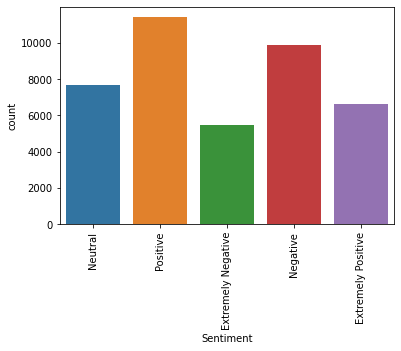

In [ ]:
sns.countplot(data=train_df, x = 'Sentiment')
plt.xticks(rotation=90)

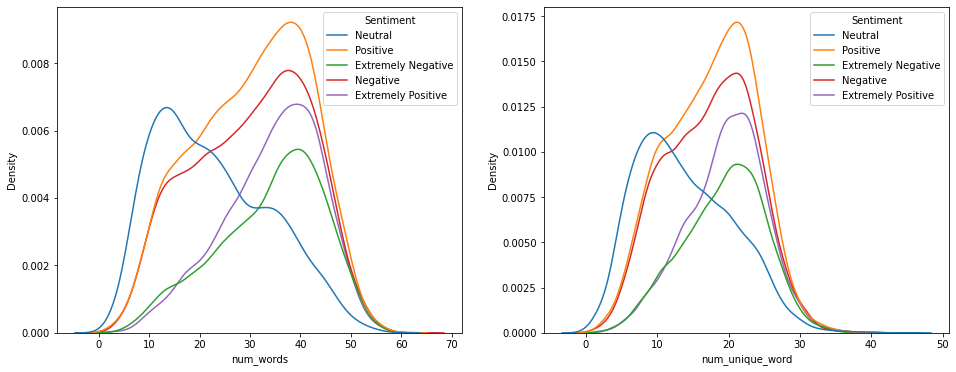

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.kdeplot(data=train_df, x='num_words', hue='Sentiment')

plt.subplot(122)
sns.kdeplot(data=train_df, x='num_unique_word', hue='Sentiment')

From the above, we can see neutral tweets have less words and unique words on average. For other sentiments, they tend to have more words. For extreme sentiments, they tend to have a higher number of words.

Let's see the distribution of the top 15 unique words for different sentiments

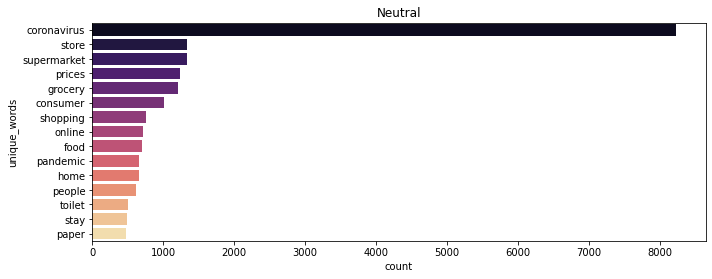

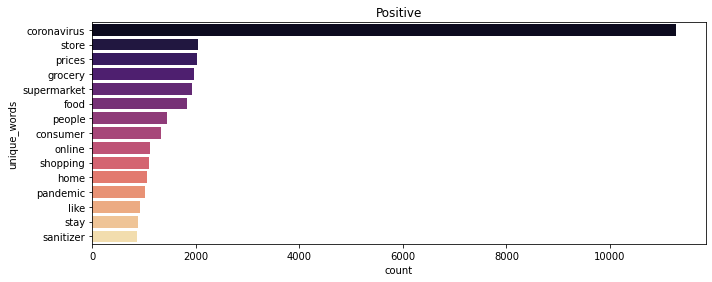

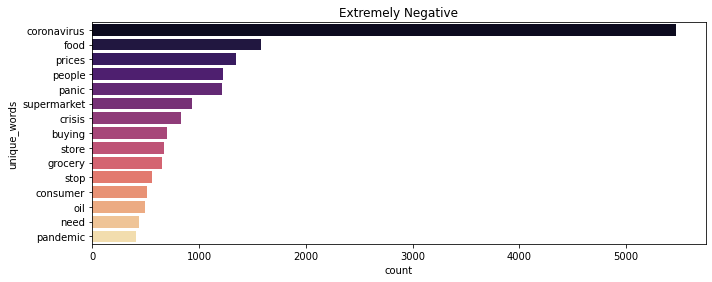

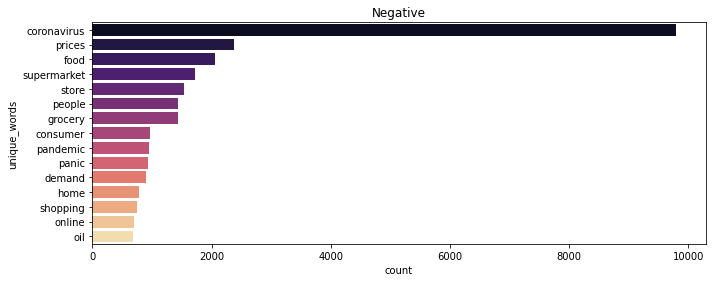

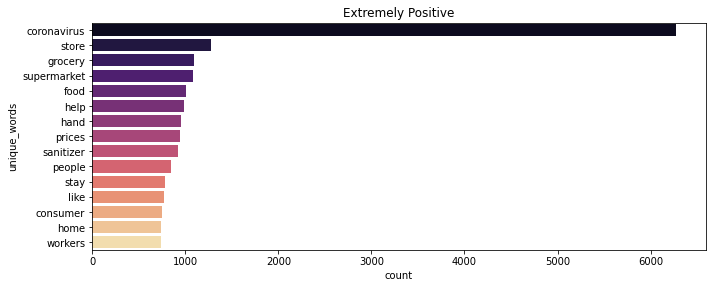

In [ ]:
#Get sentiment values
senti_values = train_df['Sentiment'].unique()
for i, value in enumerate(senti_values):
    senti_df = train_df[train_df['Sentiment'] == value]['unique_word']
    word_df = senti_df.apply(lambda x:str(x).split())
    top = Counter([item for sublist in word_df for item in sublist])
    temp = pd.DataFrame(top.most_common(15),columns=['unique_words','count'])
    
    plt.figure(figsize=(10,18))
    plt.subplot(5,1,i+1)
    sns.barplot(data=temp,x="count",y='unique_words', palette="magma")
    plt.title(value)
    plt.tight_layout()

    
    
    

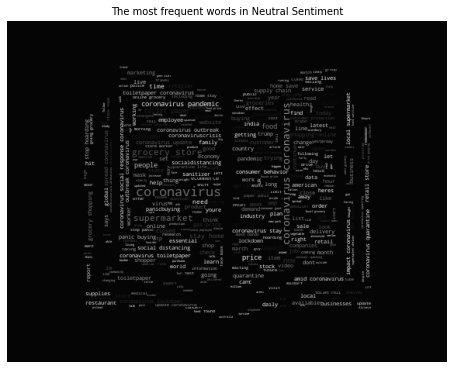

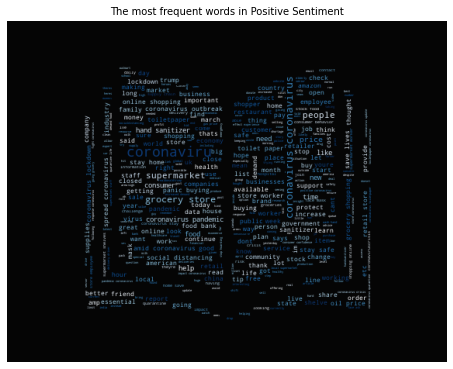

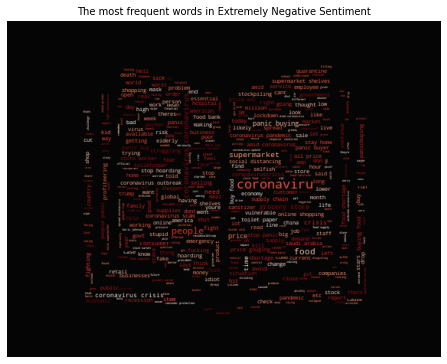

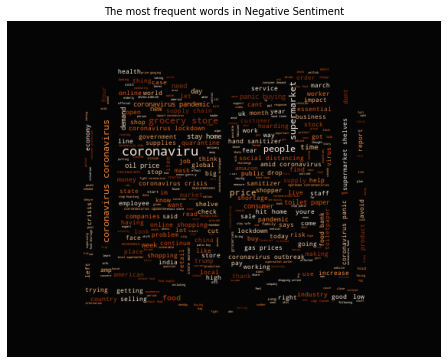

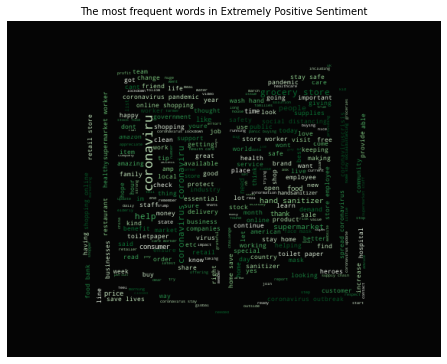

In [ ]:
cmap = ['Greys', "Blues" , 'Reds', 'Oranges', 'Greens']
for i, value in enumerate(senti_values):
    plt.figure(figsize=(20,15))
    plt.subplot(3,2,i+1)
    mask=np.array(Image.open("/content/book-logo-1.jpeg"))
    mask=mask[:,:,1]
    subset=train_df[train_df['Sentiment'] == value]
    text=subset['unique_word'].values
    wc= WordCloud(background_color="black",max_words=500,mask=mask,stopwords=stopwords)
    wc.generate(" ".join(text))
    plt.axis("off")
    plt.title(f"The most frequent words in {value} Sentiment", fontsize=10)
    plt.tight_layout()
    plt.imshow(wc.recolor(colormap = cmap[i]), alpha=0.98)

# Ngrams analysis
We will now plot n-grams

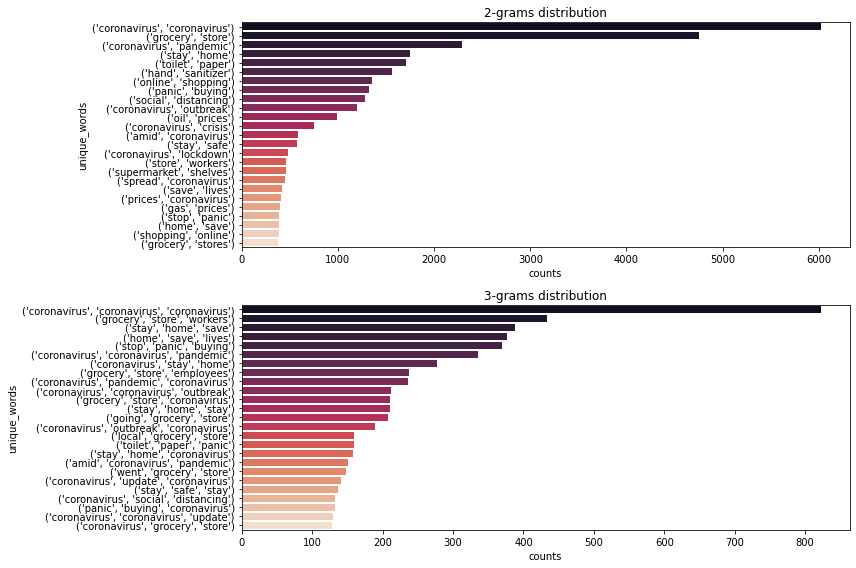

In [ ]:
def plot_ngram(series, n, num):
    words = ' '.join(series)
    df = ((pd.Series(nltk.ngrams(words.split(), n)).value_counts())[:num]).rename_axis('unique_words').reset_index(name='counts')
    sns.barplot(data=df, x="counts", y = "unique_words", palette="rocket")
    plt.title(f"{n}-grams distribution")

plt.figure(figsize=(12,8))
plt.subplot(211)
plot_ngram(train_df['unique_word'],2,25)
plt.tight_layout()
plt.subplot(212)
plot_ngram(train_df['unique_word'],3,25)
plt.tight_layout()

# Preprocessing for model training

We will now group the sentiments to 3 classes, Negative, Positive and Neutral

In [ ]:
def label_encode_sentiment(text):
    if text == "Extremely Negative":
        text = "Negative"
    elif text == "Extremely Positive":
      text = "Positive"
    return text
    
train_df['Sentiment'] = train_df['Sentiment'].apply(label_encode_sentiment)
test_df['Sentiment'] = test_df['Sentiment'].apply(label_encode_sentiment)

In [ ]:
train_df['Sentiment'].value_counts()

Positive    18039
Negative    15392
Neutral      7686
Name: Sentiment, dtype: int64

# Model training using AWD_LSTM architecture

We will now concatenate train_df and text_df and put it in Fastai's dataloader and split to new train and validation sets

In [ ]:
df = pd.concat([train_df,test_df])
dls_lm= TextDataLoaders.from_df(df, text_col='OriginalTweet', label_col='Sentiment', valid_pct=0.2,is_lm=True)
dls_lm.show_batch(max=3)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj once a week i go grocery shopping at our local saveonfoods store in xxmaj north xxmaj vancouver i must say , the staff and management have been great . xxmaj lots of xxmaj social xxmaj distancing measures put in place , and , most importantly , lots of food . xxmaj some products are limited , but no panic over here . xxbos is an economic issue as well as","xxmaj once a week i go grocery shopping at our local saveonfoods store in xxmaj north xxmaj vancouver i must say , the staff and management have been great . xxmaj lots of xxmaj social xxmaj distancing measures put in place , and , most importantly , lots of food . xxmaj some products are limited , but no panic over here . xxbos is an economic issue as well as a"
1,"low income living week to week who can t xxmaj or the elderly person who can t get out often amp now has nothing xxbos xxmaj when inhuman profiteering is skyrocketing in xxmaj pakistan making hand sanitizers and face masks as rare commodities , xxmaj indian xxup fmcg companies slash the prices of hand sanitizers … . xxbos xxmaj this is our civic and patriotic duty xxmaj this xxmaj bay xxmaj area","income living week to week who can t xxmaj or the elderly person who can t get out often amp now has nothing xxbos xxmaj when inhuman profiteering is skyrocketing in xxmaj pakistan making hand sanitizers and face masks as rare commodities , xxmaj indian xxup fmcg companies slash the prices of hand sanitizers … . xxbos xxmaj this is our civic and patriotic duty xxmaj this xxmaj bay xxmaj area pot"
2,and individuals now and going forward . xxmaj did they help during coronavirus xxmaj pandemic or not xxmaj make informed consumer decisions . xxmaj reward heroes . xxmaj do n't support xxunk . xxmaj find out here . coronavirus xxmaj help compassion xxbos xxmaj scammers are taking advantage of fears surrounding the coronavirus . coronavirus xxunk xxup ftc xxmaj learn more from the xxmaj federal xxmaj trade xxmaj commission : xxunk xxbos,individuals now and going forward . xxmaj did they help during coronavirus xxmaj pandemic or not xxmaj make informed consumer decisions . xxmaj reward heroes . xxmaj do n't support xxunk . xxmaj find out here . coronavirus xxmaj help compassion xxbos xxmaj scammers are taking advantage of fears surrounding the coronavirus . coronavirus xxunk xxup ftc xxmaj learn more from the xxmaj federal xxmaj trade xxmaj commission : xxunk xxbos 19
3,"adventures blog posts , webinars and podcasts ! xxbos xxmaj hi there xxmaj to help contain the coronavirus spread in xxmaj ghana xxmaj xxunk xxmaj merchants xxmaj ghana wishes to announce to its clients that we would be providing a 200ml hand sanitizer containing 70 xxmaj ethyl xxmaj alcohol in each of your packages for xxup free xxmaj yes xxup free xxup of xxup charge xxbos i see the empty supermarket shelves","blog posts , webinars and podcasts ! xxbos xxmaj hi there xxmaj to help contain the coronavirus spread in xxmaj ghana xxmaj xxunk xxmaj merchants xxmaj ghana wishes to announce to its clients that we would be providing a 200ml hand sanitizer containing 70 xxmaj ethyl xxmaj alcohol in each of your packages for xxup free xxmaj yes xxup free xxup of xxup charge xxbos i see the empty supermarket shelves i"
4,"out , and xxmaj drop off . xxup turn xxup off social media and the news . xxmaj be informed , but limit exposure . xxup tune xxup out fake news , panic buying xxup drop xxup off there that need help , food , xxunk coronavirus love xxmaj quarantine xxbos xxmaj thank you to all of our recovery focus staff who have gone the extra mile this last couple of weeks",", and xxmaj drop off . xxup turn xxup off social media and the news . xxmaj be informed , but limit exposure . xxup tune xxup out fake news , panic buying xxup drop xxup off there that need help , food , xxunk coronavirus love xxmaj quarantine xxbos xxmaj thank you to all of our recovery focus staff who have gone the extra mile this last couple of weeks to"
5,"health tec

Then we'll pass the dataloader to the pretrained language model learner and fine-tune it.

SuggestedLRs(valley=0.005248074419796467)

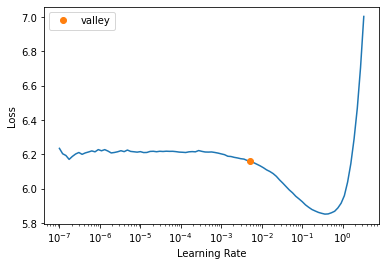

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=accuracy, wd=0.1)
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 5e-3)

#Save the pretrained model
learn.save_encoder('finetuned')

epoch,train_loss,valid_loss,accuracy,time
0,4.532158,4.269204,0.273266,02:15
1,4.248398,4.088127,0.289228,02:16
2,4.003027,3.982537,0.300487,02:16
3,3.744731,3.908795,0.310724,02:17
4,3.538426,3.912371,0.312312,02:18


We will then use create a text classifier learner using previous pretrained AWD_LSTM and then fine-tune on it

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


SuggestedLRs(valley=0.007585775572806597)

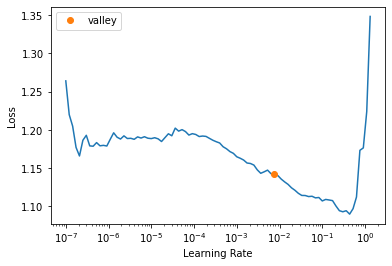

In [ ]:
dls_clas = TextDataLoaders.from_df(df, text_col='OriginalTweet', label_col='Sentiment', valid_pct=0.2, text_vocab=dls_lm.vocab)
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

#Load previous encoder
learn = learn.load_encoder('finetuned')
learn.lr_find()

Now we finished training our Language Model. We will then create a text classifier and train it based on the fine-tuning of the language model

In [ ]:
#Define some callbacks in the training
early_stop = EarlyStoppingCallback(min_delta=0.01, patience=3)
model_save = SaveModelCallback()
reduce_lr = ReduceLROnPlateau(min_delta=0.01, patience=2, factor = 100 ,min_lr=1e-8)

#unfreeze all layers and train
learn.unfreeze()
learn.fit_one_cycle(n_epoch = 20, lr_max=0.0075,cbs=[early_stop,model_save,reduce_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.141574,0.401800,0.883434,01:31
1,0.123664,0.470423,0.874416,01:31
2,0.119356,0.496544,0.868960,01:31
3,0.147224,0.490780,0.870185,01:32


Better model found at epoch 0 with valid_loss value: 0.4017995595932007.
Epoch 2: reducing lr to 1.2746091156550471e-05
No improvement since epoch 0: early stopping


# Model Interpretation of AWD_LSTM model
Let's check our model result

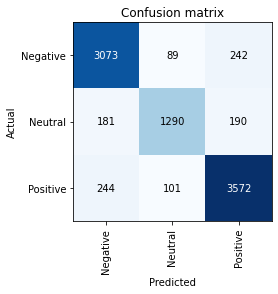

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Let's check the validation accuracy of our final model and check the precision and recall

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
y_hat, y = flatten_check(interp.decoded, interp.targs)
valid_acc = accuracy_score(y, y_hat)

print("Validation accuracy: " + str(valid_acc))
print('-'*100)
print(classification_report(y, y_hat,target_names=['Negative','Neutral','Positive']))

Validation accuracy: 0.8834335337341349
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.88      0.90      0.89      3404
     Neutral       0.87      0.78      0.82      1661
    Positive       0.89      0.91      0.90      3917

    accuracy                           0.88      8982
   macro avg       0.88      0.86      0.87      8982
weighted avg       0.88      0.88      0.88      8982



Let's find out the top loss of the prediction and see if we can improve it

In [ ]:
interp.plot_top_losses(20)

,input,target,predicted,probability,loss
0,"xxbos xxmaj panic buying , lockdowns may drive world food inflation : xxup fao , analysts coronavirus",Neutral,Negative,0.9993707537651062,14.929080963134766
1,xxbos xxmaj polish beef reportedly shunned by supermarket shoppers,Neutral,Negative,0.9959329962730408,13.208320617675781
2,xxbos xxmaj supermarket workers and drivers are struggling to keep up with demand coronavirus,Neutral,Negative,0.9993496537208557,11.966262817382812
3,xxbos the 19 in coronavirus stands for how many lbs you gain from xxunk junk food while selfisolating,Neutral,Positive,0.9988424181938171,10.413853645324707
4,xxbos xxunk : xxmaj xxunk hiring spree continues as it faces unprecedented demand by xxunk coronavirus coronavirus retail grocery food tech,Neutral,Negative,0.9974563717842102,9.892406463623047
5,xxbos coronavirus xxmaj crisis xxmaj here are the prices at which the retail price of essential items has been capped,Neutral,Negative,0.9983115196228027,9.417145729064941
6,"xxbos .. by using food industry in it 's headline re : clickbait , this article explains the hardships that xxmaj seattle xxmaj taco xxmaj truck 's are currently facing .. coronavirus",Neutral,Negative,0.9933981895446777,8.977408409118652
7,"xxbos xxmaj price of gas in xxmaj guelph , xxup on thus morning . xxmaj guelph , xxmaj ontario",Neutral,Positive,0.9988799691200256,8.907069206237793
8,"xxbos coronavirus , xxmaj oil xxmaj price spell recession for xxmaj kazakhstan . xxup gdp ' to fall xxunk ' coronaviruscrisis",Neutral,Negative,0.9984948635101318,8.698049545288086
9,xxbos xxmaj is soap better than hand sanitizer at killing coronavirus a chemistry professor explains : why soap is so good at killing coronavirus via wef,Neutral,Negative,0.6283159255981445,8.286803245544434


In [ ]:
#Check the most confused classification
interp.most_confused()

[('Positive', 'Negative', 244),
 ('Negative', 'Positive', 242),
 ('Neutral', 'Positive', 190),
 ('Neutral', 'Negative', 181),
 ('Positive', 'Neutral', 101),
 ('Negative', 'Neutral', 89)]

We can see the meaning of the most of the text is ambigious, maybe there are some labeling issue. So far 88.34% accuracy is good enough. And next we can explore the transformer.

# Model training using BERT
We will use Blurr library as the wrapper for BERT transformer to fit in fastai library for training. 
In this notebook, I will use `AutoModelForSequenceClassification` for model class, and `AutoConfig` for the config. The pretrained model we use is "distilbert-base-uncased"

In [ ]:
#Define the model class
model_cls = AutoModelForSequenceClassification

#Define the pretrained model we want to use, this time "distilbert-base-uncased"
pretrained_model_name = "distilbert-base-uncased"


config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = 3

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls, config=config)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Create a dataloader object by defining the TextBlock and Datablock
df = pd.concat([train_df,test_df])
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks,  get_x=ColReader('OriginalTweet'), get_y=ColReader('Sentiment'), splitter=RandomSplitter(0.2))

dls = dblock.dataloaders(df, bs=64)

SuggestedLRs(valley=5.248074739938602e-05)

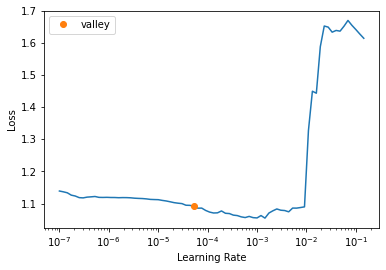

In [ ]:
#Create our model and find the best learning rate
model = HF_BaseModelWrapper(hf_model)

#Create a Learner object
learn1 = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn1.unfreeze()
learn1.lr_find()

In [ ]:
#Define some callbacks in the training
early_stop = EarlyStoppingCallback(min_delta=0.01, patience=3)
model_save = SaveModelCallback()
reduce_lr = ReduceLROnPlateau(min_delta=0.01, patience=2, factor = 100 ,min_lr=1e-8)

#Training
learn.fit_one_cycle(20, lr_max=5e-5, cbs=[early_stop,model_save,reduce_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.714037,0.693210,0.722000,02:46
1,0.490688,0.475860,0.825317,02:54
2,0.344375,0.372277,0.872968,02:54
3,0.283694,0.340931,0.887442,02:54
4,0.225392,0.309499,0.897907,02:54
5,0.156347,0.342683,0.889668,02:54
6,0.107681,0.400172,0.889334,02:53
7,0.084789,0.413660,0.891784,02:53
8,0.065171,0.467681,0.895903,02:53


Better model found at epoch 0 with valid_loss value: 0.6932098269462585.
Better model found at epoch 1 with valid_loss value: 0.47585996985435486.
Better model found at epoch 2 with valid_loss value: 0.37227749824523926.
Better model found at epoch 3 with valid_loss value: 0.34093132615089417.
Better model found at epoch 4 with valid_loss value: 0.3094993829727173.
Epoch 6: reducing lr to 4.784245197031051e-07
Epoch 8: reducing lr to 4.173528277978069e-07
No improvement since epoch 4: early stopping


Using BERT transformer greatly improve our model. The valid loss drops from 0.4018 to 0.309499

# Model interpretation of BERT modek

In [ ]:
#Get prediction on our validation set
preds,targs = learn.get_preds()
preds = torch.argmax(preds,dim=1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

valid_acc = accuracy_score(preds, targs)

print("Validation accuracy: " + str(valid_acc))
print('-'*100)
print(classification_report(targs, preds,target_names=['Negative','Neutral','Positive']))

Validation accuracy: 0.8979069249610332
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.88      0.92      0.90      3379
     Neutral       0.94      0.79      0.86      1674
    Positive       0.90      0.92      0.91      3929

    accuracy                           0.90      8982
   macro avg       0.91      0.88      0.89      8982
weighted avg       0.90      0.90      0.90      8982



Our model's F1 score also greatly improves with the new model

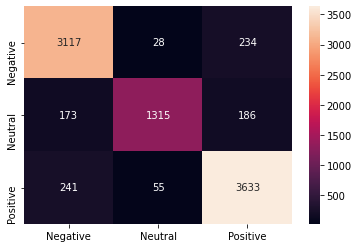

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(targs, preds),index=['Negative','Neutral','Positive'],columns=['Negative','Neutral','Positive'])
sns.heatmap(df_cm, annot=True, fmt='g') 